<a href="https://colab.research.google.com/github/Stephane-Lpt/AI-experiments/blob/main/SL/Fine-tuning/Unsloth_Guide_Optimize_and_Speed_Up_LLM_Fine_Tuning_(1)_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install


In [ ]:
# Following this tutorial: https://www.datacamp.com/tutorial/unsloth-guide-optimize-and-speed-up-llm-fine-tuning
# !pip install uv
# !uv self update
# !uv pip install unsloth torch
!pip install unsloth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 5.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.6/191.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/5

In [ ]:
!pip install -U bitsandbytes

# Finetuning

In [ ]:
from huggingface_hub import login
from google.colab import userdata
hf_token = userdata.get("HUGGINGFACE_TOKEN")
login(hf_token)

In [ ]:
import wandb
from google.colab import userdata

wb_token = userdata.get("wandb")

wandb.login(key=wb_token)
run = wandb.init(
    project='Fine-tune Llama-3.1-8B-bnb-4bit on lighteval-Math Dataset',
    job_type="training",
    anonymous="allow"
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: augerau (augerau-augerau) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 2048
dtype = None

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.9: Fast Llama patching. Transformers: 4.48.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

The prompt style includes a system prompt, instruction, and a placeholder for input and response.

In [ ]:
prompt_style = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
You are a math genius. Solve the following problem using step-by-step reasoning in the following format:
Step 1: Describe the first transformation.
Step 2: Solve an intermediate equation.
Step 3: Continue simplifying.
Your final answer should be placed after ####

Question: If the system of equations
  3x + y = a
  2x + 5y = 2a
has a solution (x,y) when x=2, compute a.

### Input:
{}

### Response:
{}"""

After that, create the function that will use the prompt style to input the math problems and solutions, converting them into the proper text. Make sure to add EOS_TOKEN to avoid any reputation.

In [ ]:
EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    inputs       = examples["problem"]
    outputs      = examples["solution"]
    texts = []
    for input, output in zip(inputs, outputs):
        text = prompt_style.format(input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

In [ ]:
from datasets import load_dataset

train_dataset = load_dataset("DigitalLearningGmbH/MATH-lighteval", split="train[0:7500]")
train_dataset = train_dataset.map(
    formatting_prompts_func,
    batched=True,
)

val_dataset = load_dataset("DigitalLearningGmbH/MATH-lighteval", split="test[0:200]")
val_dataset = val_dataset.map(
    formatting_prompts_func,
    batched=True,
)

test_dataset = load_dataset("DigitalLearningGmbH/MATH-lighteval", split="test[4800:5000]")
test_dataset = test_dataset.map(
    formatting_prompts_func,
    batched=True,
)

README.md:   0%|          | 0.00/8.41k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.99M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.86M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    lora_alpha=16,
    lora_dropout=0,
    bias="none",

    use_gradient_checkpointing="unsloth",
    random_state=3407,
    use_rslora=False,
    loftq_config=None,
)

Unsloth 2025.3.9 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        evaluation_strategy = "steps",  # Enable evaluation during training
        eval_steps = 10,                # Evaluate every 10 steps
    ),
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
start_gpu_memory = torch.cuda.memory_allocated() / 1024 / 1024 / 1024  # In GB
max_memory = torch.cuda.get_device_properties(0).total_memory / 1024 / 1024 / 1024  # Total GPU memory in GB

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 7,500 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040/4,582,543,360 (0.92% trained)


Step,Training Loss,Validation Loss
10,0.641400,0.546442
20,0.601800,0.528368
30,0.626900,0.521829


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


In [ ]:
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

24.6748 seconds used for training.
0.41 minutes used for training.
Peak reserved memory = 7.816 GB.
Peak reserved memory for training = 2.319 GB.
Peak reserved memory % of max memory = 53.021 %.
Peak reserved memory for training % of max memory = 15.731 %.


# Validate/Test finetuned model

In [ ]:
print(train_dataset)

Dataset({
    features: ['problem', 'level', 'solution', 'type', 'text'],
    num_rows: 7500
})


In [ ]:
print(val_dataset)

Dataset({
    features: ['problem', 'level', 'solution', 'type', 'text'],
    num_rows: 200
})


In [ ]:
eval_results = trainerEval.evaluate(eval_dataset=val_dataset)
print("Validation Results:", eval_results)

ValueError: No columns in the dataset match the model's forward method signature. The following columns have been ignored: [solution, level, problem, type, text]. Please check the dataset and model. You may need to set `remove_unused_columns=False` in `TrainingArguments`.

# Small tests

In [ ]:
from IPython.display import display, Markdown

# Assurez-vous d'avoir le bon modèle et tokenizer
FastLanguageModel.for_inference(model)

inputs = tokenizer(
    [
        prompt_style.format(
            "If the system of equations \begin{align*} 3x+y&=a,\\ 2x+5y&=2a, \end{align*} has a solution $(x,y)$ when $x=2$, compute $a$. Do not forget to put your final answer after a boxed format",
            "",
        )
    ],
    return_tensors="pt",
).to("cuda")

# Générer la sortie du modèle
outputs = model.generate(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    max_new_tokens=250,
    use_cache=True,
)

response = tokenizer.batch_decode(outputs)

# Utilisation de Markdown pour rendre la réponse proprement interprétable en LaTeX
latex_response = response[0].split("\n\n### Response:")[1].strip()

print(latex_response)

# Affichage de la réponse en Markdown avec interprétation LaTeX
display(Markdown(f"### Solution: \n\n {latex_response}"))


From the second equation, $2x+5y=2a$, we see that $2x+5y=2(3x+y)$.  Therefore, $2x+5y=6x+3y$, so $3y=4x$, or $y=\frac43x$.  Substituting this into the first equation, we get $3x+\frac43x=a$, or $4x=\frac{3}{4}a$.  Therefore, $a=\boxed{\frac{16}{3}}$.<|end_of_text|>


### Solution: 

 From the second equation, $2x+5y=2a$, we see that $2x+5y=2(3x+y)$.  Therefore, $2x+5y=6x+3y$, so $3y=4x$, or $y=\frac43x$.  Substituting this into the first equation, we get $3x+\frac43x=a$, or $4x=\frac{3}{4}a$.  Therefore, $a=\boxed{\frac{16}{3}}$.<|end_of_text|>

In [ ]:
import re

def extract_final_answer_gsm8k(text):
    match = re.search(r'####\s*(-?\d+/\d+|-?\d+)', text)
    return match.group(1) if match else None

def extract_final_answer_model(text):
    """
    Extracts the content inside LaTeX \boxed{} from a given text.

    :param text: A string containing expressions with \boxed{}.
    :return: A list of extracted contents (empty if no match).
    """
    return re.findall(r'\\boxed{(.*?)}', text)

def evaluate_gsm8k(model, tokenizer, problems):
    correct = 0
    total = len(problems)

    for problem, correct_answer in problems:
      FastLanguageModel.for_inference(model)

      inputs = tokenizer(
          [
              prompt_style.format(
                  problem + "Do not forget to put your final answer after a boxed format",
                  "",
              )
          ],
          return_tensors="pt",
      ).to("cuda")

      # Générer la sortie du modèle
      outputs = model.generate(
          input_ids=inputs.input_ids,
          attention_mask=inputs.attention_mask,
          max_new_tokens=250,
          use_cache=True,
      )

      response = tokenizer.batch_decode(outputs, skip_special_tokens=True)

      # Utilisation de Markdown pour rendre la réponse proprement interprétable en LaTeX
      latex_response = response[0].split("\n\n### Response:")[1].strip()

      # Affichage de la réponse en Markdown avec interprétation LaTeX
      display(Markdown(f"### Solution: \n\n {latex_response}"))

      model_answer = extract_final_answer_model(latex_response)[-1]
      correct_answer = extract_final_answer_gsm8k(correct_answer)

      print(f"Correct answer is {correct_answer}")

      if model_answer == correct_answer:
          correct += 1

    accuracy = correct / total
    print(f"Model Accuracy on GSM8K: {accuracy * 100:.2f}%")

# Sample GSM8K problems
gsm8k_problems = [
    ("Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?", "Natalia sold 48/2 = <<48/2=24>>24 clips in May. Natalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May. #### 72"),
    ("Nancy, the librarian, is shelving books from the cart. She shelved 12 history books, 8 romance books, and 4 poetry books from the top section of the cart. Half the books on the bottom section of the cart were mystery books, which she quickly put back into place. Then, she shelved the remaining books from the bottom of the cart, including 5 Western novels and 6 biographies. How many books did she have on the book cart when she started?", "Half of the books on the bottom section of the cart are mystery books, which means they are the same as the number of Western novels and biographies put together. So there are 5 + 6 = <<5+6=11>>11 mystery novels. Add them all together, and there are 12 history + 8 romance + 4 poetry + 11 mystery + 5 Western + 6 biographies = <<12+8+4+11+5+6=46>>46 books total #### 46")
]

evaluate_gsm8k(model, tokenizer, gsm8k_problems)


### Solution: 

 She sold $48$ clips in April.  She then sold half as many in May, or $\frac{48}{2} = \boxed{24}$ clips.  She sold a total of $48+24=\boxed{72}$ clips.

Correct answer is 72


### Solution: 

 She shelved 12 history books, 8 romance books, and 4 poetry books from the top section of the cart. The number of books she shelved from the top section of the cart was $12+8+4=\boxed{24}$ books.

Half the books on the bottom section of the cart were mystery books, which she quickly put back into place. This means that $\frac{1}{2}$ of the books on the bottom section of the cart were mystery books. The total number of books on the bottom section of the cart was $1\cdot \frac{1}{2}$ of the books on the bottom section of the cart. Therefore, the number of mystery books was $\frac{1}{2}$ of the books on the bottom section of the cart. The number of mystery books was $5+6=\boxed{11}$ books.

Then, she shelved the remaining books from the bottom of the cart, including 5 Western novels and 6 biographies. The number of books she shelved from the bottom of the cart was $5+6=\boxed{11}$ books.

The total number of books on the book cart was $24+11+11=\boxed{46}$

Correct answer is 46
Model Accuracy on GSM8K: 100.00%


In [ ]:
new_model_online = "Augerau/Llama-3.1-8B-MATH"
new_model_local = "Llama-3.1-8B-MATH"
model.save_pretrained(new_model_local) # Local saving
tokenizer.save_pretrained(new_model_local) # Local saving

('Llama-3.1-8B-MATH/tokenizer_config.json',
 'Llama-3.1-8B-MATH/special_tokens_map.json',
 'Llama-3.1-8B-MATH/tokenizer.json')

In [ ]:
from huggingface_hub import login
from google.colab import userdata
hf_token = userdata.get("HUGGINGFACE_TOKEN")
login(hf_token)
model.push_to_hub(new_model_online) # Online saving
tokenizer.push_to_hub(new_model_online) # Online saving

README.md:   0%|          | 0.00/588 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Saved model to https://huggingface.co/Augerau/Llama-3.1-8B-MATH


# Push model online

# Section of examples/tests

In [ ]:
from unsloth import FastLanguageModel
from transformers import TextStreamer

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B-bnb-4bit"
)

==((====))==  Unsloth 2025.3.4: Fast Llama patching. Transformers: 4.48.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `llm_int8_enable_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

In [ ]:
FastLanguageModel.for_inference(model)

# Load our hf model online

In [ ]:
!pip install -U bitsandbytes evaluate transformers accelerate
!pip install git+https://github.com/hendrycks/math.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.1/342.1 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Model name on Hugging Face Hub
model_name = "Augerau/Llama-3.1-8B-MATH"

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

In [ ]:
import evaluate

# Load the competition_math metric
metric = evaluate.load("competition_math")

In [ ]:
dataset = [
    {"question": "How many vertical asymptotes does the graph of $y=\frac{2}{x^2+x-6}$ have?", "answer": "2"},
    {"question": "What is the positive difference between $120\%$ of 30 and $130\%$ of 20?", "answer": "10"},
]


In [ ]:
prompt_style = """Below is an instruction that describes a task, paired with a question that provides further context. Answer to the question.

### Instruction:
You are a math genius who can solve any level of algebraic problem Please answer the following math question.
Give only the result of the equation.
I trained you to give me only the result number
Please give only the output number.
Dont justificate and dont write anything else than the number.
### Question:
{}

### Answer:
{}"""

def generate_answer(question):
    inputs = tokenizer(
        [
            prompt_style.format(
                question,
                "",
            )
        ],
        return_tensors="pt",
    ).to("cuda")

    # Générer la sortie du modèle
    outputs = model.generate(
      input_ids=inputs.input_ids,
      attention_mask=inputs.attention_mask,
      max_new_tokens=250,
      use_cache=True,
    )

    response = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    return response[0].split("\n\n### Answer:")[1].strip()

# Run predictions
predictions = [generate_answer(example["question"]) for example in dataset]
references = [example["answer"] for example in dataset]

print(predictions)
print(references)

['The denominator of this function is $x^2+x-6$, which factors as $(x+3)(x-2)$.  This means that the graph has vertical asymptotes at $x=-3$ and $x=2$.  There are two vertical asymptotes.', 'We have $120\\% \\cdot 30 = 120\\cdot 30 = 3600$ and $130\\% \\cdot 20 = 130\\cdot 20 = 2600$. The difference is $3600 - 2600 = \\boxed{1000}$.']
['2', '8']


In [ ]:
results = metric.compute(predictions=predictions, references=references)

# Print Evaluation Results
print("Competition Math Score:", results)

Competition Math Score: {'accuracy': 0.0}


# LLM pipeline principle

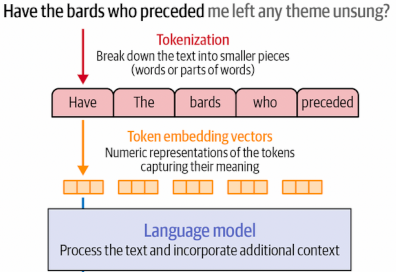

In [ ]:
# Defining a string template to give context to the model to make him answering a way we want.
prompt_style = """
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}
"""

# Tokenize the string
inputs = tokenizer(
    [
        prompt_style.format(
            "You are a professional machine learning engineer",
            "How would you deal with NaN validation loss?",
            "",
        )
    ],
    return_tensors="pt", # Specify the output format of the tensors (Pytorch)
).to("cuda") # Store the tensors in the gpu ram (instead of cpu ram) to make it faster

text_streamer = TextStreamer(tokenizer) # Handle the generating text process correctly
_ = model.generate(**inputs, streamer=text_streamer, max_new_tokens=128)


In [ ]:
# # Example that we can code and decode a string with the class tokenizer
# inputs = tokenizer("What is the capital of France?", return_tensors="pt")
# input_tokens = inputs["input_ids"][0].tolist()

# # Afficher les tokens d'entrée
# print("Tokens d'entrée:", input_tokens)

# # Décoder les tokens d'entrée
# decoded_input = tokenizer.decode(input_tokens, skip_special_tokens=True)
# print("Texte décodé des inputs:", decoded_input)